# Image Classification with Test-Time Adaptation Project

### Important notice

This html file only contains the relevant code and relevant results. The implementation of the dataset, serializing functions, some interactive plots, hyperparameter selection, testing... Can be found in the jupyter notebook from the [github project repository](https://github.com/javiimo/ImageClassificationAssignment).

### Project Overview

"*Test Time Adaptation*" (TTA) refers to a technique in AI where a model is adapted or fine-tuned at the time of inference, using the data it is currently processing.
The target of TTA techniques is to improve model's performance over new or unseen data. In other words, improving the effectiveness when test samples are sampled from a distribution different from the training set one. This latter phenomenon is called  *domain shift*.

The purpose of this work is to implement known methods to mitigate the domain shift problem via TTA, and to suggest new approaches.

The model used is CLIP ViT-B/32, and the test dataset is ImageNet-A.

The strategies implemented are:

1. Marginal Entropy Minimization with One test point (MEMO)
2. Contrastive Prompt Tuning (CoOp) with Test-time Prompt Tuning (TPT)
3. Candidates Boosting (CB)
4. Descriptive labeling, Generalized similarities, Adaptive temperature (DGA)

Where the first 2 points are based on existing papers, the latter ones are of our own.

Furthermore, we will explore the integration of monocular depth estimation, utilizing the Depth Anything model, into our image classification pipeline to try to enhance performance.

### The Team

This project is conducted under the supervision of Dr. Elisa Ricci and Dr. Francesco Tonini. Our team comprises:

- Pietro Begotti
- Javier Montané Ortuño 

# 0. Imports and Loading Clip

In [ ]:
import clip

# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import Subset
from torchvision.transforms.functional import to_pil_image

# linalg and math tools
import numpy as np
from scipy.optimize import fsolve
from scipy.special import softmax

# utility
import traceback
import boto3
import os
import json
import copy
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from dataclasses import dataclass, asdict
from typing import List, Dict


# Visualizing results
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ipywidgets import widgets, Dropdown, Output, VBox, Button
from IPython.display import display

# dictionary + adaptive temp
import nltk
import re
nltk.download('wordnet')
from nltk.corpus import wordnet

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# in order to avoid problems with the backpropagation step with Adam, all parameters of the model are set to torch.float32
for param in model.parameters(): param.data = param.data.to(torch.float32)

# 1. Functions' descriptions and implementations

In this section every model is staged as a class. Every class will get the labels' embeddings in ```__init__ (self, ... )``` and will have the method  ```__call__(self, image)``` that will output ```predicted, prob, entropy```: predicted label, probability distribution over all the classes, entropy of the distribution.

In order to make the code cleaner, inheritance is used.

## 1.1 Useful functions


The class ```model_methods``` is made by a set of functions which don't employ neither CLIP or any class specific variable.


### 1.1.1 Theorecial standpoint

It's worth mentioning here why ``` get_entropy(self, logits) ``` has such an implmementation.
Let $n$ be the number of samples, and $k$ the number of classes.
Consider $$X = (x_{ij})_{i = 1, \ldots n,j = 1, \ldots k}$$
the matrix of logits, where $x_{ij}$ is the $j-th$ logit of the $i-th$ sample, and $p_{ij}$ be the probability output given by the softmax applied on the $i-th$ row.

Then the log of the marginal probability of belonging to a class is
$$
\begin{align*}
\log ( \bar{p}_j )
&= \log \biggl( \frac{1}{n}\sum_i^n p_{ij} \biggr) \\
&= \log \biggl( \frac{1}{n}\sum_i^n p_{ij} \biggr) \\
&= \log \biggl( \frac{1}{n}\sum_i^n \frac{e^{x_{ij}}}{ \sum_h e^{x_{ih}}} \biggr) \\
&= \log \biggl( \sum_i^n e^{z_{ij}} \biggr) - \log(n) \\
\end{align*}
$$
where $z_{ij} = x_{ij} - \log \sum_h^k e^{x_{ik}}$.

Computing $z_{ij}$ first and then using the upper formula to get $\log{\bar{p}_j}$ is more stable, as $\log$ oprations are done over a sum of elements rather than just a single one.

### 1.1.2 Code

In [ ]:
class model_methods:

  def get_entropy(self, logits):

    """
    Calculate the entropy of the logits tensor.

    Parameters:
    logits (torch.Tensor): Input tensor of logits.

    Returns:
    torch.Tensor: Entropy of the logits tensor.
    """

    z = logits - logits.logsumexp(dim = -1, keepdim=True)     # compute z_ij
    marginal_logp = z.logsumexp(dim=0) - np.log(z.shape[0])   # compute marginal log probabilities

    min_real = torch.finfo(marginal_logp.dtype).min           # for numerical stability, the smallest representable number given the dtype of logits.
    avg_logits = torch.clamp(marginal_logp, min = min_real)   # put a threshold to avoid underflow

    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)


  def get_augmentations(self, image, num_augmentations = 32, transformations = None, manual_seed = None):

    """
    Generate augmented images from the input image.

    Parameters:
    image (PIL.Image): Input image to augment.
    num_augmentations (int, optional): Number of augmented images to generate (default is 32).
    transformations (torchvision.transforms.Compose, optional): Transformations to apply for augmentation.
    manual_seed (int, optional): Manual seed for reproducibility of random augmentations.

    Returns:
    torch.Tensor: Batch of preprocessed augmented images of dimension (num_augmentations + 1, 3, 224, 224).
    """

    if transformations == None:

        #Set a seed for reproducibility of the random augmentations
        if manual_seed != None: torch.manual_seed(manual_seed)

        transformations = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
        ])

    # Add the original image to the batch of augmentations
    augmented_images = [self.preprocess(image).unsqueeze(0).to(self.device)]


    for _ in range(num_augmentations):
        augmented_images.append(self.preprocess(transformations(image)).unsqueeze(0).to(self.device))

    batch = torch.vstack(augmented_images)
    return batch


  def get_synonyms(self, word):

    """
    Retrieve synonyms of a word using WordNet library.

    Parameters:
    word (str): Input word to find synonyms.

    Returns:
    set: Set of synonyms of the input word.
    """

    # set object to avoid duplicates
    synonyms = set()

    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            # .lower() to have only lower case characters
            # CLIP tokenization maps elements with lower/upper case characters into the same embedding.
            synonyms.add(lemma.name().lower())

    return synonyms


  def get_definitions(self, word):

    """
    Retrieve definitions of a word using WordNet library.

    Parameters:
    word (str): Input word to find definitions for.

    Returns:
    list: List of definitions (strings) of the input word from WordNet.
    """
    definitions = [] # no overlapping problem this time.

    for syn in wordnet.synsets(word):
      definitions.append(syn.definition())

    return definitions


  def get_temperature(self, x, beta = 0.5 + np.log(2 * np.pi * np.exp(1))):

    """
    Compute the temperature parameter for a set of logits such that the temperature (after applying softmax) of
    the distribution equals beta.

    Parameters:
    x (torch.Tensor): Input tensor for which temperature is computed.
    beta (float, optional): Temperature parameter to batch. The default value 0.5 + np.log(2 * np.pi * np.exp(1))
                            is the entropy of a standard gaussian N(0,1).

    Methods:
    entropy(tau): Taylor approximation (order 5) of the function to minimize

    Returns:
    root (torch.Tensor): temperature value
    """

    n = x.shape[0]
    x_np = x.cpu().numpy()

    x_max = np.max(x_np)


    def entropy(tau): # The structure of the function is explained at 1.5

      y = x_np * tau
      p = softmax(y)

      den = np.ones(n) + y + y**2 / 2 + y**3 / 6 + y**4 / 24 + y**5/120
      num = y * den

      H = - np.sum(num) / np.sum(den) + tau * x_max + np.log(n) / 2
      return H - beta

    initial_guess = 100.0  # Initial guess for tau
    root = fsolve(entropy, initial_guess)

    return torch.tensor(root).to(device)


## 1.2. Clip class

The ```clip_model``` class provides an basic immplementation of CLIP model, in the same fashion of the one provided [in the official GitHub page](https://github.com/openai/CLIP).

However, this class is used, similar to ```model_methods```, to store a set of useful methods that will be inherited by the other classes, such as getting label and image embeddings, and getting probability distributions.

### 1.2.1 Code

In [ ]:
class clip_model(model_methods):

  def __init__(self, model, preprocess, dataset_classes = None):

    """
    constructor of clip_model class.

    Parameters:

    model (torch.nn.Module): CLIP model instance.
    preprocess (callable): Preprocessing function for images.
    dataset_classes (list or None, optional): List of dataset classes for initializing text features.

    """

    self.device = next(model.parameters()).device # self.device is in the same device as model variable.
    self.model = model
    self.preprocess = preprocess
    self.text_features = None

    if dataset_classes != None: self.get_text_features(dataset_classes)

  def get_text_features(self, dataset_classes):

    """
    Extract text features for a list of dataset classes.

    Parameters:
    dataset_classes (list): List of strings for dataset classes.
    """
    # to get text features: get tokens, encode tokens, normalize.

    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in dataset_classes]).to(self.device)
    with torch.no_grad():

      self.text_features = self.model.encode_text(text_inputs)

      # by default, torch.norm gives the Frobenious one. Set p = 2 to get the euclidean one.
      self.text_features /= self.text_features.norm(dim = -1, p = 2, keepdim=True)


  def get_image_features(self, image):

    """
    Extract image features.

    Parameters:
    image (PIL.Image): Input image to extract features from.

    Returns:
    image_features (torch.Tensor): normalized embedding of the image.
    """

    image_prep = self.preprocess(image).unsqueeze(0).to(self.device)

    with torch.no_grad():

      image_features = self.model.encode_image(image_prep) # image features contains the embeddings of all the elements of the class.
      image_features = image_features / image_features.norm(dim = -1, p = 2, keepdim = True)

    return image_features

  def get_candidates(self, reference, candidates, num_candidates):

    """
    Retrieve top candidates based on similarity scores with a reference.

    Parameters:
    reference (torch.Tensor): Reference tensor for comparison. (e.g. image embedding)
    candidates (torch.Tensor): Candidate tensors to compare against. (e.g. text embeddings)
    num_candidates (int): Number of top candidates to retrieve. (e.g. retain the top scoring text embeddings)

    Returns:
    candidates (torch.Tensor): Top candidate tensors.
    label_indeces.squeeze() (torch.Tensor): Indices of top candidates.
    """

    logits = reference @ candidates.T
    _, label_indeces = torch.topk(logits, num_candidates)
    candidates = candidates[label_indeces].squeeze()

    return candidates, label_indeces.squeeze()


  def get_closest_features(self, target, candidates, num_candidates):

    """
    This function operates very similarly to get_candidates.
    Here, candidates is a list of strings and labels corresponding to highest scoring
    elements aren't returned.

    Parameters:
    target (torch.Tensor): Target tensor for comparison.
    candidates (list): List of strings representing candidate text inputs.
    num_candidates (int): Number of closest features to retrieve.

    Returns:
    picked_features (torch.Tensor): Closest feature tensors to the target.
    """

    with torch.no_grad():

        tokens = torch.cat([clip.tokenize(c) for c in candidates]).to(device)

        features = model.encode_text(tokens)
        features /= features.norm(dim = -1, p = 2, keepdim=True)

    picked_features, _ = self.get_candidates(target, features, num_candidates = num_candidates)
    return picked_features


  def get_prob(self, tensor1, tensor2, custom_temp = None, adaptive_temp = False):

    """
    Returns the probability distributions whose logits are given by
    similarities between rows of tensor1 and columns of tensor2.

    Parameters:
    tensor1 (torch.Tensor): First tensor for similarity computation. (e.g. image embedding)
    tensor2 (torch.Tensor): Second tensor for similarity computation. (e.g. text embeddings)
    custom_temp (float, optional): Custom temperature parameter for softmax scaling. (More to explain at 1.5)
    adaptive_temp (bool, optional): Flag indicating whether to use adaptive temperature scaling.

    Returns:
    logits (torch.Tensor): Scaled logits based on temperature.
    logits.softmax(dim = -1).squeeze() (torch.Tensor): Softmax probabilities of the logits.
    """

    logits = tensor1 @ tensor2.T

    if adaptive_temp:

      for i in range(logits.shape[0]):

        temp = self.get_temperature(logits[i].unsqueeze(0))
        logits[i] = temp * logits[i]

    else:

      temp = self.model.logit_scale.exp() if custom_temp == None else custom_temp
      logits = temp * logits

    return logits, logits.softmax(dim = -1).squeeze()


  @torch.no_grad()
  def __call__(self, image, custom_temp = None):

    """
    Perform inference on an image and return prediction, probability distribution and entropy.

    Parameters:
    image (PIL.Image): Input image for inference.
    custom_temp (float, optional): Custom temperature parameter for softmax scaling.

    Returns:
    predicted.item() (int): Predicted class index.
    prob (torch.Tensor): probability distribution over the classes.
    entropy (float): Entropy of the probability distribution.
    """

    self.model.eval()

    image_features = self.get_image_features(image)
    logits, prob = self.get_prob(image_features, self.text_features,
                                 custom_temp=custom_temp)


    predicted = torch.argmax(prob)
    entropy = self.get_entropy(logits).item()


    return predicted.item(), prob, entropy

## 1.3 MEMO class

### 1.3.1 Theoretical standpoint

Marginal Entropy Minimization with One test point (MEMO) is an algorithm of Test Time Adaptation, whose complete description can be found in [its paper](https://arxiv.org/pdf/2110.09506.pdf).

The implementation of the method follows what is written in section 3 of the paper:

Let $p_\theta(c|x)$ be the output probability of class $c$ given the input $x$ and model with parameters $\theta$, and $x_0$ the test input:

1. Let $x_1, \ldots x_n$ be the $n$-uple, given by $n$ augmentations of the original sample $x_0$. We shall collect all those elements in a single tensor, which will act as mini-batch for future gradient descent step.

2. Compute the probability distributions for every element of the mini-batch, say $p_\theta(\cdot | x_i)$ .  The model’s average, or $marginal$, output distribution with respect to the augmented points is given by $$ \bar{p}_\theta(c | x) = \frac{1}{n}\sum_{i = 0}^n p_\theta(c | x_i) $$
and compute its $marginal$ entropy $H(\bar{p}_\theta(\cdot | x))$.

4. Using the entropy as a loss function, perform a single update step (so backpropagation), which gives the updated parameters $\theta'$.

5. Predict $c^\star = argmax_c p_{\theta '}(c | x_0) $.



The entropy of a random variable $X$ with discrete distribution $p$ is defined as:
$$H(X) = \sum_i^n p_i \log (p_i) \quad \text{where } p_i = \mathbb{P}(X = x_i) \quad \text{and we set } 0 \log(0) := 0$$
To compute it, we need to be careful with underflow/overflows caused by $\log$ function. Hence the need for a more stable algorithm to compute the entropy: ```get_entropy```

### 1.3.2 Code

In [ ]:
class MEMO_model(clip_model):

  def __init__(self, model, preprocess, dataset_classes = None,
               optimizer = 'SGD', num_augmentations = 32, lr = 1e-5):

    """
    Initialize MEMO_model class. Works similar to clip_model class.

    Parameters:

    optimizer (str, optional): Type of optimizer for the backpropagation setp ('SGD' or 'ADAM').
    num_augmentations (int, optional): Number of augmentations to generate during training.
    lr (float, optional): Learning rate for the optimizer.
    """


    super().__init__(model, preprocess, dataset_classes)

    self.optimizer = None
    self.optimizer_type = optimizer

    self.num_augmentations = num_augmentations

    self.lr = lr



  def use_ADAM(self): self.optimizer = optim.Adam(self.model.parameters(), lr = self.lr)
  def use_SGD(self): self.optimizer = optim.SGD(self.model.parameters(), lr = self.lr)


  def set_optimizer(self, s):

    """
    Set the optimizer.

    Parameters:
    s (str): Type of optimizer ('ADAM' or 'SGD').
    """

    if   s == 'ADAM': self.use_ADAM()
    elif s == 'SGD' : self.use_SGD()
    else: print('wrong input')


  def require_model_gradients(self, state = True):
    """
    Set the requires_grad attribute of model parameters to the specified state. Needs to be true to perform backpropagation.

    Parameters:
    state (bool): Flag indicating whether to require gradients (True) or not (False).
    """
    for param in self.model.parameters(): param.requires_grad = state



  def backprop_sweep(self, image):

    """
    Performs a backpropagation sweep.

    Parameters:
    image (PIL.Image): Input image for training.
    """

    self.set_optimizer(self.optimizer_type)

    try:

      # set model.train(True) and zero the gradients
      self.model.train(True)
      self.optimizer.zero_grad()

      # get the augmentations of the image, then the embeddings and euclidean normalization.
      batch = self.get_augmentations(image, num_augmentations = self.num_augmentations, manual_seed = 33)

      batch_features = self.model.encode_image(batch)
      batch_features = batch_features / batch_features.norm(dim = -1, p = 2, keepdim = True)

      # get the logits end compute the entropy to compute the forward pass
      logits = self.model.logit_scale.exp() * batch_features @ self.text_features.T
      loss = self.get_entropy(logits)

      # backward step
      loss.backward()
      self.optimizer.step()


    except Exception as e:

      print(f"Exception{type(e).__name__} occurred. Details: {e.args}")



  def __call__(self, image):

      """
      Perform inference on an image and return prediction, probability distribution and entropy.
      MEMO inference consists in performing the backpropagation step and then the forward pass in
      the exact fashion as clip_model.

      Parameters and Returns same as clip_model.
      """

      # store a copy of the original parameters
      original_params = {name: param.clone().detach() for name, param in self.model.named_parameters()}

      self.require_model_gradients(state = True) # Require gradients to update the CLIP parameters
      self.backprop_sweep(image)

      self.require_model_gradients(state = False)

      # clip_model __call__
      predicted, distribution, entropy = super().__call__(image, custom_temp = 100.0)

      # Restore original parameters
      with torch.no_grad():

        for name, param in self.model.named_parameters():
          param.copy_(original_params[name])


      return predicted, distribution, entropy

### 1.3.3 A few remarks

*   It's a non trivial task to set the learning rate of the optimizer properly. In fact since the loss function, *the entropy*, is minimized for high confidence predictions regardless of the correctness of the prediction itself: setting it too high will destroy model's parameters and therefore giving lots of erroneus predictions. On the other hand though if the learning rate is way too little then the backpropagation step won't be effectful enough. Setting ```lr = 1e-5``` seems an ok in-between.


*   In information theory literature to compute the entropy of a random variable it is usually employed the base 2 logarithm, $\log_2$. In this implementation we use the classical base $e$ log but this is not only formally correct but also does not influence the backpropagation step as it just differs from $log_2$ by a multiplicative constant ($\frac{1}{\log_e(2)}$).

* The number of augmentations does not have a huge impact on the outcome. However, the more augmentations the more accuracy at the price of a reduced confidence - averaging to a higher number of probability distributions will land a less peaked distribution, hence more entropy, but gains more robustness to domain shifts.




## 1.4 CB class - Candidates Boosting

### 1.4.1 Theoretical standpoint

In Test Time Adaptation, a possible techique to improve generalization capabilities of the model relies on lowering the entropy of the output distribution. MEMO achieves this by performing a backpropagation sweep where the loss function is tailored explicitly for this purpose.

*Low entropy is synonym of confident prediction*, which should provide robustness (or rather, *consistency*) under "tiny" domain shifts, which is the problem tackled in this project.

However, even though low entropy values are desirable to have, they should be obtained as a *consequence* of the testing algorithm rather than the target of the process itself; as in principle, confident predictions does not imply correct ones.

Even though it would be wizardry (or cheating) to have any indication about how accurate the prediction is without knowing the real label, working on robustness seems a path worth undertaking. However, there are a couple of remarks worth to be discussed:

*   Augmentations are a crucial tool to improve stability under domain shifts, but helpful only if they're "**good ones - or, in other words, the best candidates -**": performing too many transformation to an image may lead to something completely off target.
*   TTA doesn't make miracles: a good algorithm can only make a difference in high-uncertainty scenarios, where the target is to change (hopefully for the good) the outcome of the raw output, or reinforcing the confidence in the prediction.
*   Training is out of the scope: it leads to slow inference, and potentially harming the model's structure.

**How to choose good augmentations?**

The answer of this question is highly non trivial, as extracting the *right* features from the image itself is a hard task. Applying multiple transformations to the original image simultaneusly may lead to augmentations that have almost nothing in common with the original, hence potentially leading to wrong outputs when it comes to classification.

A possible solution for choosing good crops would be to rely on external models to "wisely" choose the most meaningful parts of the image. An example is [I-JEPA](https://github.com/gaasher/I-JEPA) (Image-based Joint-Embedding Predictive Architecture) and we will explore this possibility with a much smaller model for depth estimation. In this section we propose a simpler alternative.

Our work starts from this key consideration: *Finding good augmentations is equivalent to having a metric that evaluates the the goodness of the augmentations themselves*. Now the problem relies on finding the appropriate metric.

For this purpose, the choice is to **select augmentations whose embeddings are closest to the original image's one**. Given that *transformations within a neural network are all continuous*, this proximity in embedding space indicates that the closest augmentations retain more knolwedge of the original image.

(This latter statement is intuitive, even though a bit vague, since there is no structure over the space of images when we think of them in terms of their semantic content rather than as tensors of RGB values. It is possible to induce a topology in this space given by the counterimages of open sets of the embedding function, but still there would be no metric. It can be proved that such a topology is Hausdorff if the embedding is injective, but it is not the purpose of this work.)

Clearly, such an algorithm can make the difference only in a scenario with high uncertainty. In fact, if the image embedding lies close to a decision boundary between multiple labels, then considering where its closest augmentations lie may *suggest* which label to choose. In this scenario, it is unnecessary to consider labels with low cosine similarity scores, as they are far from the image embedding.

Since CLIPs embeddings are all normalized (with respect to the $p = 2$ norm) it's worth noting that

$$
d(x,y)^2 = \| x - y \|^2 = ( x-y, x-y) = \|x\|^2 + \|y\|^2 - 2(x , y) = 2( 1 - (x,y) )
= 2(1 - \text{sim}(x,y) )
$$

hence the lower the distance, the higher the cosine similarity.


In the following image, the lighblue dot is the original image embedding, the green dots are the topk closest embeddings of the augmentations, the red dots are the otehr embeddings. Lines represent decision boundaries between classes.

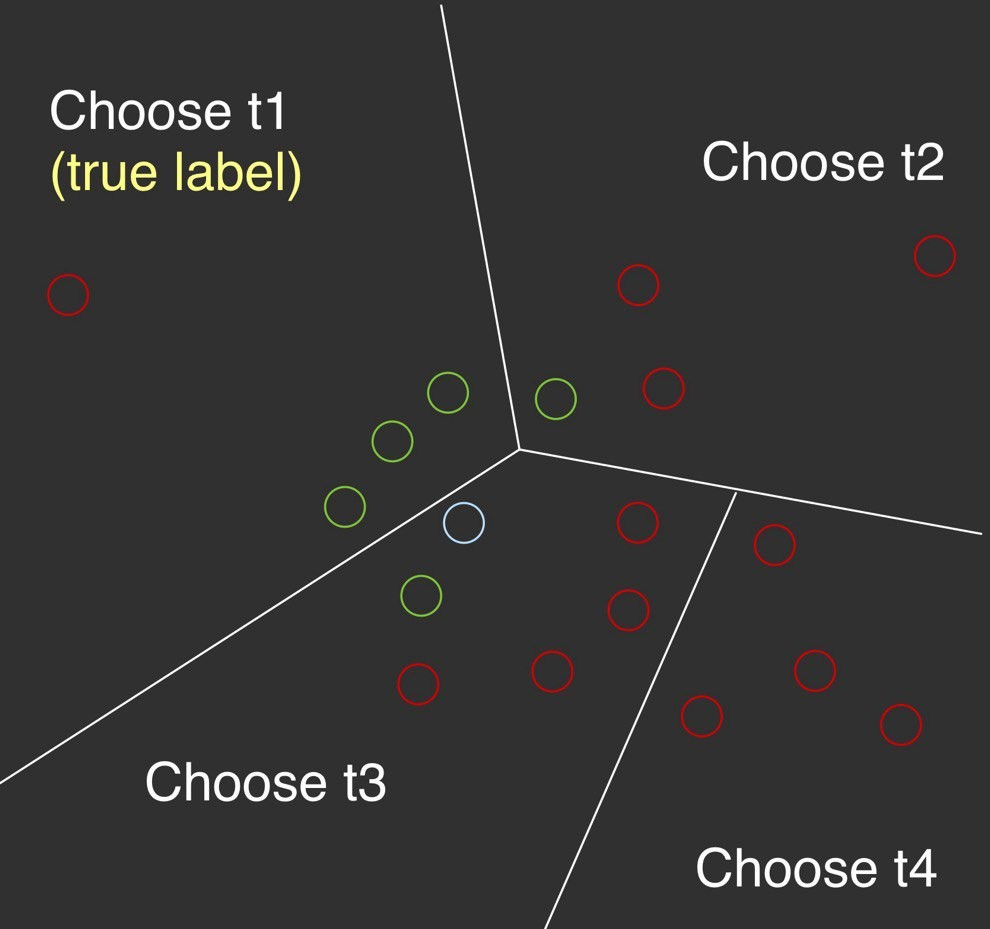

Moreover, **focusing only on the top-scoring labels (got from a first raw test of the original image) - i.e. the best candidates -** is more efficient and removes a the "noise" coming from the labels with lowest score. In such a way, the output probability distributions will involve only a few candidates, therefore making the process computationally more efficient and lowering the *entropy* of the probability distribution that now involve just a few components. Or, equivalently, sets a probability of 0 for the non top-scoring labels.

### 1.4.2 Code

In [ ]:
class cb_model(clip_model):

  # __init__ same as clip
  def __init__(self, model, preprocess, dataset_classes = None,
               num_augmentations = 32, num_pick_augmenations = 15, num_candidates = 5, max_iter = 15, adaptive_temp = False):

    """
    Initializes.

    Parameters:
    same as clip_model. Moreover
    num_augmentations (int): Number of augmentations to generate.
    num_pick_augmenations (int): Number of augmentation candidates to select based on similarity.
    num_candidates (int): Number of text candidates to select based on similarity.
    max_iter (int): Maximum iterations for refining predictions.

    """

    super().__init__(model, preprocess, dataset_classes)

    self.num_augmentations = num_augmentations
    self.num_pick_augmenations = num_pick_augmenations
    self.num_candidates = num_candidates
    self.max_iter = max_iter

    self.adaptive_temp = adaptive_temp

    # by default, transformations to apply to get augmentations are just random crops, as they seem the most effective.
    self.transformations = transforms.Compose([transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333))])



  def get_and_pick_augmentations(self, image, image_features, text_candidates):

    """
    Generates augmentations from the given image, retains the best candidates, computes the average probability distribution.

    Parameters:
    image (torch.Tensor): Input image tensor.
    image_features (torch.Tensor): Feature embeddings of the input image.
    text_candidates (torch.Tensor): Embeddings of text candidates for classification.

    Returns:
    aug_prob (torch.Tensor): Probability distribution over text candidates after candidates augmentation.
    """

    # get all augmentation tokens
    batch = self.get_augmentations(image, num_augmentations = self.num_augmentations, transformations = self.transformations)

    aug_img_features = model.encode_image(batch)
    aug_img_features = aug_img_features / aug_img_features.norm(dim = -1, p = 2, keepdim = True)

    # pick the ones closest to the original image
    similarities_aug = image_features @ aug_img_features.T
    _, pick_indeces = torch.topk(similarities_aug, self.num_pick_augmenations)

    # for every augmentation candidate, compute the probability distribution over the text candidates.

    picked_aug_features = torch.squeeze(aug_img_features[pick_indeces]).detach()
    _, aug_probs = self.get_prob(picked_aug_features, text_candidates, adaptive_temp = self.adaptive_temp)

    aug_prob = aug_probs.mean(dim = 0).squeeze() # average over the augmentation candidates' distributions

    return aug_prob



  @torch.no_grad()
  def __call__(self, image):

    """
    Performs inference on the input image using confidence boosting.

    Parameters:
    image (torch.Tensor): Input image tensor.

    Returns:
    predicted (int): Predicted label index.
    prob (torch.Tensor): Probability distribution over text candidates.
    entropy (float): Entropy of the output probability distribution.
    """

    self.model.eval()

    # get image embedding, and get the text candidates chosen by cosine similarities
    image_features = self.get_image_features(image)
    text_candidates, label_indeces = self.get_candidates(image_features, self.text_features, self.num_candidates)

    # image probability distribution over the text candidates labels
    _, img_prob = self.get_prob(image_features, text_candidates, adaptive_temp = self.adaptive_temp)
    aug_prob = None
    output_prob = img_prob.clone()

    running_predict = torch.argmax(output_prob)

    iter = 1
    while iter < self.max_iter:

      # probability distribution given by augmentations
      new_aug_prob = self.get_and_pick_augmentations(image, image_features, text_candidates)

      # average between the new probability of the augmentations and the old one
      if aug_prob == None: aug_prob = new_aug_prob
      else:                aug_prob = ( (iter - 1) * aug_prob + new_aug_prob) / iter

      # the output probability is given by an average between the image probability and the augmentations probability
      output_prob = 0.6 * img_prob + 0.4 * aug_prob

      predict_step = torch.argmax(output_prob)

      # running predict is the prediction up to the previous step. predict_step is the prediction given by the current output probability.
      # Therefore, if running_predict and predict_step do not agree, it means that aug_prob swings the decision over another label.
      # Since the stochastic nature of the augmentation process (maybe augmentations change predictions for the good, maybe for the bad)
      # in such case it's worth investigating more,
      # hence another round of the loop, which  will generate more augmentations - making the process more stable -
      if running_predict == predict_step: break
      running_predict = predict_step

      iter += 1


    predicted = label_indeces[predict_step].item()

    # the prob output will be over all the text features, assigning probability 0 to the non candidates ones.
    prob = torch.zeros(self.text_features.shape[0]).to(self.device)
    prob[label_indeces] = output_prob
    entropy = - (output_prob * torch.log(output_prob)).sum()

    return predicted, prob, entropy

## 1.5 DGA (Dictionary, Generalized similarities, Adaptive temperature)

### 1.5.1 Theoretical standpoint

In order to improve prediction at test time, in many of the algorithms proposed the information flow starts from augmentations of the image itself. But what about switching the roles and augment the labels available? In order to do so, there are a few obstacles to overcome.

The first problem relies on the nature of the model itself, that may not allow additional labels. Fortunately this is not the case in the current framework as CLIP provides an embedding function for *any* string, whether it's a word or a sentence. So *it's definitely worth exploiting this possibility*.

The second issue to resolve, which is where our work focused on, is *which labels to choose*. CoOp relies on learnable parameters to better suit prompts to the images. However, having learnable parameters implies that a model needs to be trained on some dataset. Apart from the resources spent in training those parameters, it is not clear that CoOp will perform well on classes that weren't present in the training set, which might lead to weak generalization capabilities if the training set isn't diverse enough. To address this problem, we try to go through a simpler path that allows to inject additional labels for every class.


**Descriptive labeling**

The simplest way of having additional (and *meaningful*) information about a class, i.e. a word, is to describe it. For example "boy" can be described by words such as "young", "male", "school". Another approach is to use the description of the word itself: "a male child, from birth to full growth, especially one less than 18 years of age". In other words, *synonyms and definitions*.
From here on the trajectory starts to be quite clear: using these descriptions to compute the similarities with the image. High values of those will suggest that "boy" is the label to go.

Fortunately, there's an obvious way to avoid hardcoding all those *descriptive labels*, as someone else already did the job for us, writing down a dictionary.

For a class then, the work comes down to looking at its synonyms and its definitions, and embed them. However, different classes may have a different number of those items, which leads to a inhomogeneous set of descriptive labels, so it's better to set a fixed number of labels to pick and chose the best candidates per class. Then, in the same fashion as ```candidates boosting```, keep only the items closest to the class embedding and get the output probability as a weighted average of the probabilities of the original image and the descriptive labels probability.


It's clear that such a process needs to be done only *once*, before inference time, making this method way faster than lots of its competitors.

**Generalizing cosine similarities**

To compute the probability distribution given by descriptive labels, a different approach than averaging between probabilities is pursued.

In CLIP's framework all vectors are normalized, hence the cosine similarity coincides with the scalar product. So it holds that

$$ (x,y) x = \Pi _{\text{span} \langle x \rangle } (y)
$$

$i.e.$ the scalar product $(x,y)$ is the coefficient of the *projection* of $y$ into the subspace generated by $x$. Let's generalize this latter statement.

Let $y \in \mathbb{R}^n$, and $\text{span} \langle x_1, \ldots x_n\rangle$ is the subspace generated by $x_i$. The projection mapping is linear, hence representable with a matrix, which has a well-known form:
$$\Pi_{\text{span} \langle x_1, \ldots x_n \rangle} = X (X^T X)^{-1} X^T$$
where $X$ is the matrix whose columns are $x_i$.

In this specific scenario, $y$ is the image embedding and $x_1, \ldots, x_n$ are the descriptive labels. All vectors are normalized.

Visually:

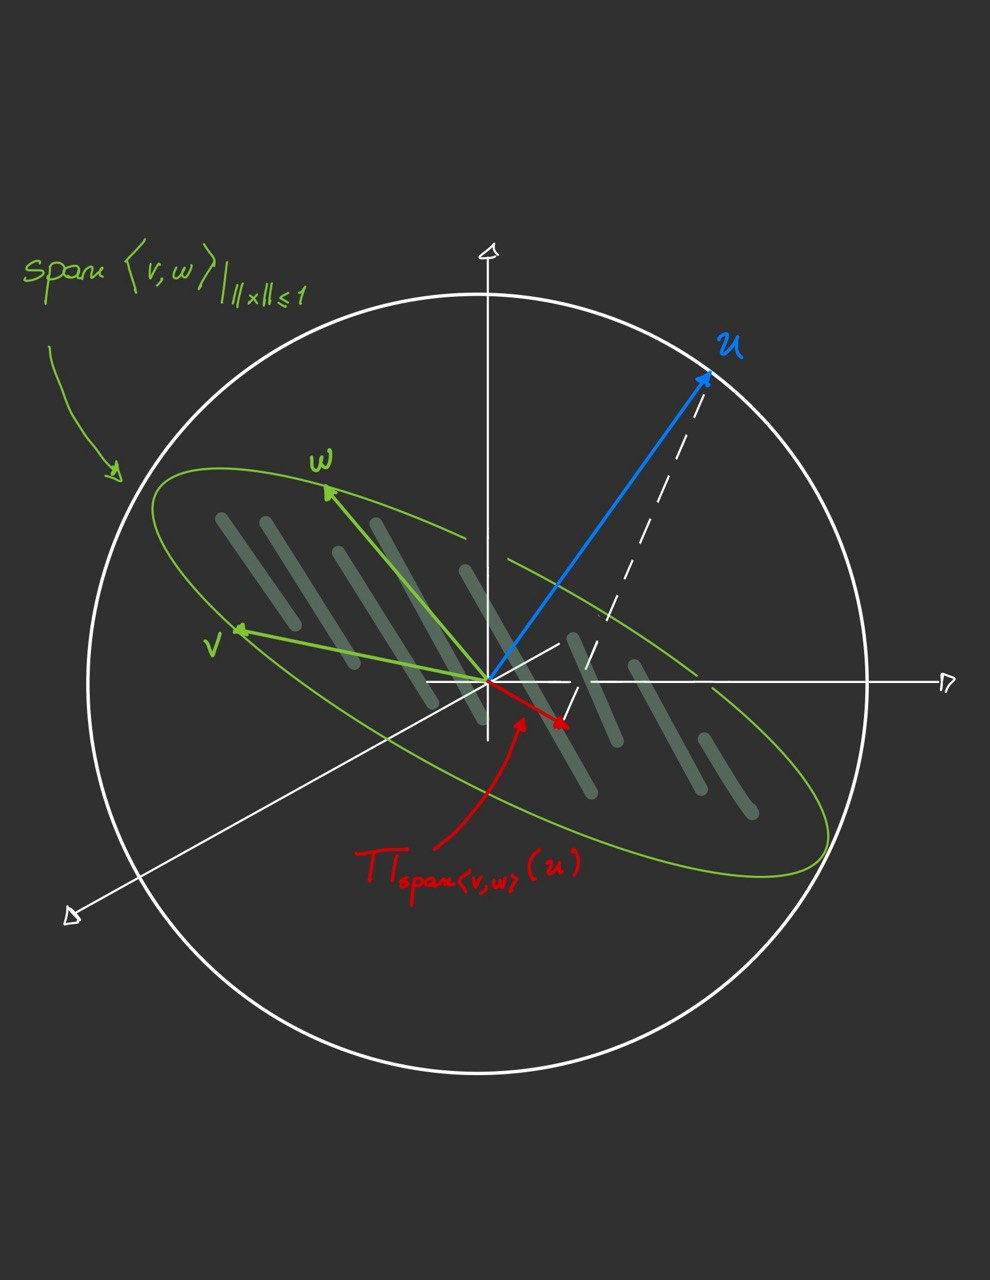

We may think of the length of the projection, $\|\Pi_{span(x_i)}(y)\|$, as a *generalization of the cosine similarity for normalized vectors when there are multiple labels for a single class*.


**Adaptive temperature**

As mentioned before, cosine similarities applied in CLIP are nothing but scalar products. As vectors lie in a high dimensional ($512$) space, due to the curse of dimensionality distances compress, resulting in logits pretty similar one to each other. It's not a suprise than that in the out-of-the-box implementation of CLIP values are multiplied by a factor of 100:
```
similarities = 100.0 * text_features @ image_features.T
```
which dilates outputs, resulting in a significant reduction of entropy when the softmax is later on applied. CLIP itself provides a learnt temperature parameter to deal with this problem.

This is a feature not to underestimate, and it is important to handle it with care when comparing two probability distributions: putting *too much* temperature and one of those may highly propend for a value - which can lead to overconfidence over a wrong label without being able to recover from it when averaging different distributions-; *too little* to become noninformative, just because of some artificial hyperparameter reduces by a certain amount the entropy.

It would be optimal to stay in that in-between spot, but this would imply *adapting* the temperature case by case. This latter part of the work focuses on *Why not trying to reverse the problem? Why not fixing the entropy to then find the correct temperature level?*  Keeping under control such a delicate parameter may help in avoiding the dangerous cases mentioned above.

To implement this though, some maths need to be put onto display. Luckly this group is mostly made by mathematicians, which (theoretically) should be able to deal with it.

Given a set of logits $(x_i)_i$ and the corresponding probability distribution (output of the softmax function) $(p_i)_i$, then the target is to have
$$H(p | \tau) = \beta$$
where $\tau$ is the temperature parameter, and $\beta$ is the fixed entropy value (hyperparameter). Then

$$
\begin{aligned}
H(p | \tau) &= - \sum_i p_i \log(p_i) \\
&= -\sum_i  \frac{e^{x_i \tau}}{\sum_j e^{x_j \tau}}
\log \biggl( \frac{e^{x_i \tau}}{\sum_j e^{x_j \tau}} \biggr) \\
&= - \frac{1}{\sum_j e^{x_j \tau}}\sum_i e^{x_i \tau} \biggl( \log(e^{x_i \tau}) - \log \Bigl( \sum_j e^{x_j \tau} \Bigr) \biggr) \\
&= - \frac{1}{\sum_j e^{x_j \tau}} \biggl( \sum_i e^{x_i \tau}x_i \tau -
\sum_i e^{x_i \tau}\log \Bigl( \sum_j e^{x_j \tau} \Bigr)  \biggr)\\
&= - \frac{\sum_i e^{x_i \tau} x_i \tau}{\sum_j e^{x_j \tau}} + \frac{\sum_i e^{x_i \tau}}{\sum_j e^{x_j \tau}}\log \sum_j e^{x_j \tau} \\
&= - \frac{\sum_i e^{x_i \tau} x_i \tau}{\sum_j e^{x_j \tau}} + \log \sum_j e^{x_j \tau}
\end{aligned}
$$

The second term of the latter sum is the *LSE (LogSumExp)* function applied to vector $x$, for which holds the inequality:

$$
\max_i \{ \tau x_i \} \leq \text{LSE}(x) \leq \max_i \{ \tau x_i \} + \log(n)
$$
where $n$ is the number of components of $x$. A reasonable approximation is given by
$$
\log \sum_j e^{x_j \tau} \approx \max_i \{ \tau x_i \} + \frac{\log(n)}{2}
$$
Regarding the first term, first recall that the logits $x_i = ( img, c_i)$ are the scalar products between the image and the class embeddings, which are both normalized. Thanks to Cauchy-Schwartz inequality:
$$
|x_i| = |(img, c_i)| \leq \|img\|\|c_i\| = 1
$$
and it is equal iif $img = c_i$. Moreover, it holds that as the dimension of the embedding space $d \rightarrow \infty $, then $x_i \rightarrow 0$ $a.s.$ ([proof here](https://math.stackexchange.com/questions/995623/why-are-randomly-drawn-vectors-nearly-perpendicular-in-high-dimensions)).
This means that $x_i$ in general is quite small. For these reasons, makes sense to approximate the exponentials with their Taylor expansions (the lower the value, the more accurate is the approximation):

$$
\frac{\sum_i e^{x_i \tau} x_i \tau}{\sum_j e^{x_j \tau}} =
\frac{\sum_i x_i\tau + (x_i\tau)^2 + \frac{(x_i\tau)^3}{2} + \frac{(x_i\tau)^4}{6} + \ldots}{\sum_j 1 + (x_j\tau) + \frac{(x_j\tau)^2}{2} + \frac{(x_j\tau)^3}{6} + \ldots}
$$

Then the expansion is truncated at some order - in this work the implementation is in ```get_temperature(...)``` function, which has an order 5 approximation - and so final equation looks as follows:

. Finally, the above equation can be approximated as follows:

$$
\frac{\sum_i x_i\tau + (x_i\tau)^2 + \frac{(x_i\tau)^3}{2} + \frac{(x_i\tau)^4}{6}}{\sum_j 1 + (x_j\tau) + \frac{(x_j\tau)^2}{2} + \frac{(x_j\tau)^3}{6}} + \max_i \{ \tau x_i \} + \frac{\log(n)}{2} - \beta = 0
$$

This equation can be then thrown into a numerical solver (```scipy.fsolve```) to get an approximation of $\tau$. Unfortunately those last steps were necessary as the numerical solvers we tried didn't work using the original expression for $H$.The hyperparameter set for $\beta$ is $\frac{1}{2}\log(2\pi e)$, which is the entropy of the standard gaussian distribution.

### 1.5.2 Code

In [ ]:
class DGA_model(clip_model):

  def __init__(self, model, preprocess, dataset_classes = None,
               num_candidates = 10, num_synonyms = 5, adaptive_temp = True):

    """
    Initializes the DGT_model instance.

    Parameters:
    num_candidates (int): Number of text candidates to consider.
    num_synonyms (int): Number of synonyms to use per class. Descriptive labels are given by a set of synonyms plus a definition
    adaptive_temp (bool): Whether to use adaptive temperature scaling in probability computation.
    """

    super().__init__(model, preprocess, dataset_classes)
    self.classes = dataset_classes
    self.num_candidates = num_candidates

    self.adaptive_temp = adaptive_temp


    self.num_synonyms = np.min([num_synonyms, 5])
    if num_synonyms > 5: print("num_synonims at most 5. Set to 5.")

    # initialize torch tensors to store descriptive labels and projection matrices
    self.descript_features = torch.empty(len(self.classes), self.num_synonyms + 1, 512).to(self.device)
    self.proj_matrices = torch.empty(len(self.classes), 512, 512).to(self.device)

    if self.text_features != None:
      self.get_descript_features()
      self.get_proj_matrix()


  def get_descript_features(self):

    """
    get descriptive labels features for each class. It fills self.descript_features

    """

    # hard coded data augmentation over the synonyms to have them above a minimum threshold, as some classes don't have synonyms.
    phrase_patterns = [ 'a photo of: ',
      'a picture of a ', 'a picture of: ',
      'an image of a ', 'an image of: '
    ]

    for i in tqdm(range(len(self.classes))):

      c = self.classes[i]

      # some classes are made by more than one word. In this case, multiple words are split and investigated independently
      words = re.split(r'[_\s]+', c) # split words if the separator is '_' or ' '

      synonyms = []
      definitions = []

      for word in words:
        definitions.extend(self.get_definitions(word)) # get all definitions of word
        synonyms.extend(self.get_synonyms(word))       # get all synonyms of word

      if len(synonyms) == 0: synonyms.append(c) # if no synonyms, use the word itself

      # strings is the list of synonyms with the hard coded augmentation
      strings = [f'{pattern}{s}' for s in synonyms for pattern in phrase_patterns]

      if len(definitions) == 0: definitions.append(c) # if no definitions, use the word itself

      # take the best num_candidates synonyms and the best definition label. Only one definition is picked as some classes just have
      # one of those
      synonyms_features = self.get_closest_features(target = self.text_features[i], candidates = strings, num_candidates = self.num_synonyms)
      context_feature   = self.get_closest_features(target = self.text_features[i], candidates = definitions, num_candidates = 1)

      self.descript_features[i, :, :] = torch.cat([synonyms_features, context_feature.unsqueeze(0)])


  def get_proj_matrix(self):

    """
    get projection matrix for each class. It fills self.proj_matrices

    """

    for i in range(len(self.classes)):

      Y = self.descript_features[i, :, :]

      # X is converted to float32 as this is the datatype required by torch.linalg.inv method.
      # Also it is transposed since the vectors needs to be organized in columns.
      X = Y.to(torch.float32).T


      # Projection matrix: X (X^T X)^-1 X^T

      gram_inv = torch.linalg.inv( torch.matmul(X.T, X)) #  gram_inv = (X^T X)^-1
      P = torch.matmul( torch.matmul(X, gram_inv), X.T)  #  P = X gram_inv X^T

      self.proj_matrices[i, :, :] = P


  def __call__(self, image):

    """
    Perform inference on an image using the Descriptive Generative Text (DGT) method.

    Parameters:
    - image (torch.Tensor): Input image tensor.

    Returns:
    - predicted (int): Predicted label index.
    - prob (torch.Tensor): Probability distribution over text candidates.
    - entropy (float): Entropy of the output probability distribution.
    """

    image_features = self.get_image_features(image)

    # similar to CB, takes only the best highest scoring classes
    text_candidates, label_indeces = self.get_candidates(image_features, self.text_features, self.num_candidates)

    projections = []

    for i in range(self.num_candidates):

      P = self.proj_matrices[label_indeces[i], :, :]

      # compute projections and their length
      project_img = torch.matmul(P, image_features.T.to(torch.float32))
      projections.append( project_img.norm(dim = 0, p = 2, keepdim = True))


    # get probability distribution for the image and use projection lengths as logits, using adaptive temperature
    _, img_prob = self.get_prob(image_features, self.text_features[label_indeces], adaptive_temp = self.adaptive_temp)

    descript_logits = torch.vstack(projections).squeeze().to(self.device)

    if self.adaptive_temp: descript_logits = self.get_temperature(descript_logits) * descript_logits # use adaptive temperature
    else: descript_logits = self.model.logit_scale.exp() * descript_logits

    descript_prob = torch.nn.functional.softmax(descript_logits, dim = 0)

    output_prob = img_prob * 0.6 + descript_prob * 0.4

    predicted_candidate = torch.argmax(output_prob)
    predicted = label_indeces[predicted_candidate].item()

    # the prob output will be over all the text features, assigning probability 0 to the non candidates ones.
    prob = torch.zeros(self.text_features.shape[0]).to(self.device)
    prob[label_indeces] = output_prob.float()
    entropy = - (output_prob * torch.log(output_prob)).sum()

    return predicted, prob, entropy

## 1.6 CoOp + TPT

### 1.6.1 Theoretical Standpoint

#### CoOp
According to the [original paper](https://arxiv.org/abs/2109.01134) that introduced Context Optimization (CoOp): "The main idea is to model a prompt’s context using a set of learnable vectors, which can be optimized through minimizing the classification loss. Two designs are proposed: one is unified context, which shares the same context vectors with all classes; and the other is class-specific context, which learns for each class a
specific set of context vectors."

The loss is backpropagated through the CLIP text encoder but only the learnable prompt is adjusted. In this project, only the unified context approach will be used with a length of 4 learnable tokens.


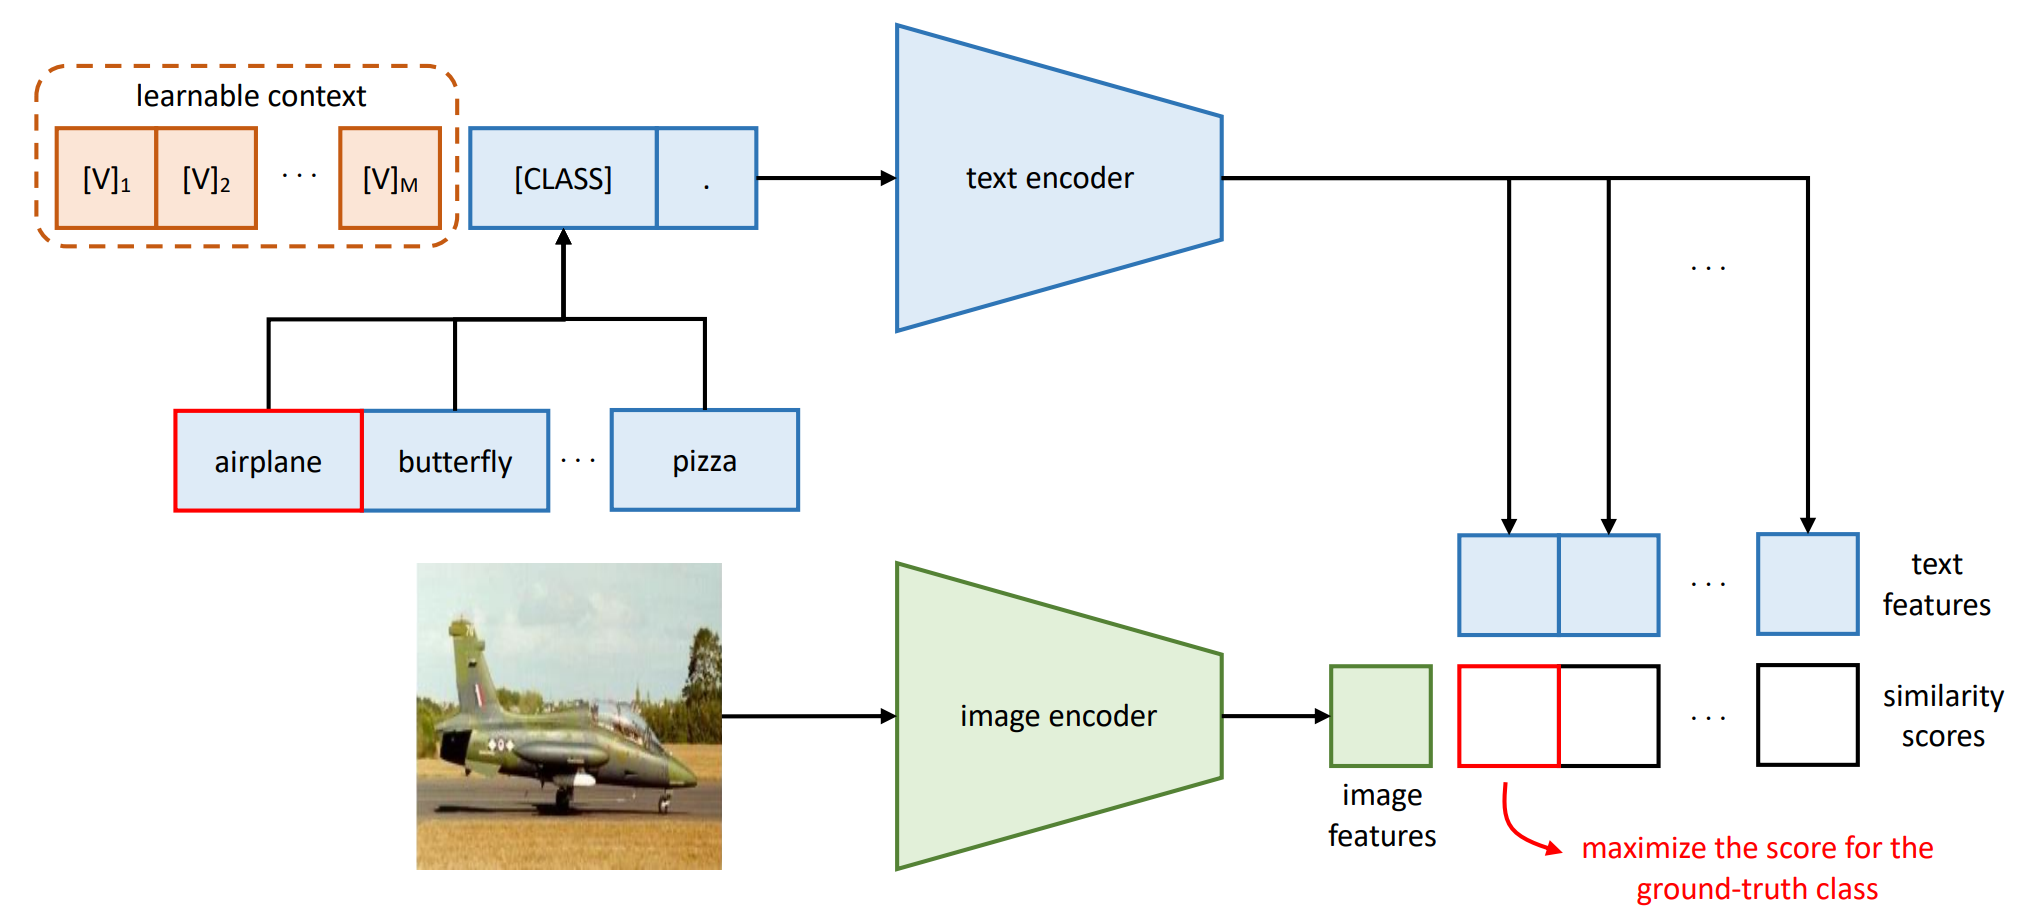

#### TPT
[Test-Time Prompt Tuning (TPT)](https://arxiv.org/pdf/2209.07511) is a method designed to enhance the performance of vision-language models like CLIP by adapting the text prompts dynamically at test time by minimizing the entropy of the prediction distribution average across "lower-entropy" augmentations.

##### Equation for Entropy Minimization:
$$ p^* = \arg\min_p -\sum_{i=1}^K \tilde{p}_p(y_i | X_{\text{test}}) \log \tilde{p}_p(y_i | X_{\text{test}}) $$
Where:
- $ p^* $ is the optimized prompt.
- $ K $ is the number of classes.
- $ \tilde{p}_p(y_i | X_{\text{test}}) $ is the averaged predicted probability for class $ y_i $.

With the Confidence-Based Averaged Probability Distribution defined as:
$$ \tilde{p}_p(y | X_{\text{test}}) = \frac{1}{\rho N} \sum_{i=1}^N 𝟙[H(p_i) \leq \tau] p_p(y | A_i(X_{\text{test}})) $$
- $ N $ is the number of augmented views.
- $ A_i(X_{\text{test}}) $ denotes the $ i $-th augmented view of the test image.
- $ \rho $ is the cutoff percentile on the N augmented views (set to 0.8 by default in our implementation).
- $𝟙[ H(p_i) \leq \tau] $ is an indicator function that filters predictions based on their entropy $ H $. We are removing the augmentations with the highest entropy (over the set percentile).


### 1.6.2 Code

We have downloaded the pretrained weights on ImageNet for 50 epocs from a [drive folder](https://drive.google.com/file/d/18ypxfd82RR0pizc5MM1ZWDYDk4j0BtPF/view) provided in the original CoOp repository. In specific, the CLIP ViT-B/32 version with M=4 (context length) and from the 3 seeds provided, we chose the second one. Notice that in Table 1 from the CoOp paper, M=4 got about 1% higher accuracy than M=16 on the test sets.

The code from CoOp is an adaptation from the [original repository](https://github.com/KaiyangZhou/CoOp/blob/main/trainers/coop.py) (also provided in lab session 3 without the need for a config file).

In [ ]:
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def shanon_entropy(x):
    #Shanon entropy in bits of a given probability distribution x
    log_x = torch.log2(x.clamp_min(1e-20))
    entropy = -torch.sum(x * log_x)
    return entropy

class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        # Initialize the TextEncoder with components from the CLIP model
        self.transformer = clip_model.transformer  # CLIP's transformer for text processing
        self.positional_embedding = clip_model.positional_embedding  # Positional embeddings for input tokens
        self.ln_final = clip_model.ln_final  # Final layer normalization
        self.text_projection = clip_model.text_projection  # Projection layer for text features

    def forward(self, prompts, tokenized_prompts):
        # prompts: tensor of shape [batch_size, n_ctx, transformer.width]
        # tokenized_prompts: tensor of shape [batch_size, 77] (CLIP uses 77 tokens max)

        # Add positional embeddings to the input prompts
        x = prompts + self.positional_embedding

        # Permute dimensions for transformer input
        # [batch_size, n_ctx, transformer.width] -> [n_ctx, batch_size, transformer.width]
        x = x.permute(1, 0, 2)

        # Pass through the text transformer (getting the text features)
        x = self.transformer(x)

        # Permute dimensions back
        # [n_ctx, batch_size, transformer.width] -> [batch_size, n_ctx, transformer.width]
        x = x.permute(1, 0, 2)

        # Apply final layer normalization
        x = self.ln_final(x)

        # Extract features from the end-of-text (eot) embedding for each sequence in the batch and then project these features using self.text_projection with a matrix multiplication
        # eot_token is assumed to be the highest number in each sequence
        # torch.arange(x.shape[0]) represents the batch indices
        # tokenized_prompts.argmax(dim=-1) finds the position of the eot token
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        # Return the final text features
        return x

class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, class_token_position, csc=False, path_to_chekpt='model.pth.tar'):
        super().__init__()
        n_cls = len(classnames)

        # Load the ctx_vector
        ctx_vector = self.load_ctx_from_checkpoint(path_to_chekpt, clip_model.token_embedding.weight.device) # torch.Size([4, 512]) [n_ctx=4, ctx_dim=512]
        n_ctx = ctx_vector.size(0)
        if clip_model.ln_final.weight.shape[0] != ctx_vector.size(1):
            raise KeyError("Context Dimension of the clip model does not match the one of the checkpoint.")

        if csc:
            # Add the n_cls dimension to the ctx_vector of size: [n_cls, n_ctx, ctx_dim]
            print("Initializing class-specific contexts")
            ctx_vector = ctx_vector.unsqueeze(0).expand(n_cls, -1, -1)
        else:
            # No need to add the n_cls dimension to the ctx_vector
            print("Initializing a generic context")
        # ctx is the learnable parameter in the prompt
        self.ctx = nn.Parameter(ctx_vector)


        # Process class names
        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompt_prefix = " ".join(["X"] * n_ctx)
        prompts = [prompt_prefix + " " + name + "." for name in classnames] # Here we use the prompt_prefix but we will only keep the tokens of the SOS, the class and EOS

        # Tokenize prompts
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(clip_model.token_embedding.weight.device)

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts)

        # Store the non-learnable tokens
        # token_prefix is the start-of-sentence token
        # token_suffix includes the class name and end-of-sentence tokens
        # register_buffer is a method in PyTorch's nn.Module class that registers a tensor as a buffer.
        # Buffers are tensors that are not considered parameters, but are part of the module's state.
        # They are not updated by the optimizer but are saved and restored in the module's state_dict.
        self.register_buffer("token_prefix", embedding[:, :1, :])
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # Numerical token representations of the string, not the learnable parameters
        self.name_lens = name_lens # length of each classname token
        self.class_token_position = class_token_position #This is an input, can be set to "front", "mid" or "back". Is where the class tokens are placed

    def load_ctx_from_checkpoint(self, checkpoint_path, device):
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))

        # Check if it is a simple state dictionary or a more complex dictionary
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint

        # Extract the ctx tensor
        if 'ctx' in state_dict:
            ctx_tensor = state_dict['ctx']
            return ctx_tensor
        else:
            raise KeyError("The 'ctx' tensor was not found in the checkpoint.")


    def forward(self):
        # Construct the full prompt embeddings
        prefix = self.token_prefix  # Start-of-sentence token
        suffix = self.token_suffix  # Class name and end-of-sentence tokens
        ctx = self.ctx  # Learnable context

        # For CoOp (non-CSC), expand ctx for all classes
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        # Combine prefix, context, and suffix based on class_token_position
        if self.class_token_position == "end":
            prompts = torch.cat(
                [
                    prefix,  # (n_cls, 1, dim)
                    ctx,     # (n_cls, n_ctx, dim)
                    suffix,  # (n_cls, *, dim)
                ],
                dim=1,
            )
        elif self.class_token_position == "middle":
            # Insert class token in the middle of the context
            half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            # Insert class token at the beginning of the context
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts  # Returns the full prompt embeddings

class CoOp_model(nn.Module):
    def __init__(self, model, preprocess, classnames, class_token_position, csc=False):
        super().__init__()
        clip_model = model

        self.prompt_learner = PromptLearner(clip_model, classnames, class_token_position, csc)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts  # Numerical token representations
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale
        self.preprocess = preprocess
        self.device = next(clip_model.parameters()).device

    def forward(self, image):
        image_features = self.image_encoder(image)

        prompts = self.prompt_learner.forward()  # Get full prompt embeddings
        tokenized_prompts = self.tokenized_prompts  # Numerical token representations of the string, not the learnable parameters
        text_features = self.text_encoder.forward(prompts, tokenized_prompts)

        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute logits
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits
    @torch.no_grad()
    def __call__(self, image):
        self.eval()
        image = self.preprocess(image).unsqueeze(0).to(self.device)
        probs = self.forward(image).softmax(dim=-1)

        prediction = torch.argmax(probs).item()
        entropy = float(shanon_entropy(probs))
        return prediction, probs.squeeze(), entropy

In [ ]:
class TPT_model(model_methods):

    def __init__(self, model, preprocess, dataset_classes, class_token_position='end', optimizer = 'SGD',
                 num_augmentations = 16, lr = 1e-5):
        self.model = model
        self.preprocess = preprocess
        self.device = next(model.parameters()).device
        self.coop = CoOp_model(model=self.model, preprocess = self.preprocess, classnames=dataset_classes,
                               class_token_position= class_token_position, csc=False).to(self.device)
        # in order to avoid problems with Adam backpropagation step, all parameters of the model are set to torch.float32
        for param in self.coop.parameters(): param.data = param.data.to(torch.float32)
        self.optim = None
        self.num_augmentations = num_augmentations
        self.lr = lr

        if optimizer == 'SGD':
            self.use_SGD()
        else:
            self.use_ADAM()


    def use_ADAM(self): self.optim = optim.Adam([{"params": self.coop.parameters()}], lr = self.lr)
    def use_SGD(self): self.optim = optim.SGD([{"params": self.coop.parameters()}], lr = self.lr)

    def confidence_selection(self, probs_matrix, percentile=0.8):
        # Compute entropies for each row in the probability matrix
        entropies = torch.tensor([shanon_entropy(row) for row in probs_matrix])

        # Find the threshold for the desired percentile
        threshold = torch.quantile(entropies, percentile, interpolation = 'linear')

        # Create a boolean mask where entropies below the threshold are selected
        boolean_mask = entropies < threshold

        # Assuming similarities is intended to be probs_matrix, return filtered matrix
        return probs_matrix[boolean_mask]

    def entropy_loss_TPT(self, probs_matrix):
        # Confidence selection for the augmented views:
        probs_matrix = self.confidence_selection(probs_matrix)
        # Average the caption probabilities across all augmentations
        avg_probs = torch.stack([row.mean() for row in probs_matrix.T])
        # Compute the entropy of the averaged probability distribution
        return shanon_entropy(avg_probs)

    def __call__(self, image):
        original_prompt_params = copy.deepcopy(self.coop.prompt_learner.ctx)
        try:
            #Turning off gradients in both the image and the text encoder
            for name, param in self.coop.named_parameters():
                if "prompt_learner" in name:
                    param.requires_grad_(True)
                else:
                    param.requires_grad_(False)
            self.coop.train()

            # Creating the augmentations
            batch = self.get_augmentations(image, self.num_augmentations)

            # Getting the probability distributions
            probs = self.coop.forward(batch).softmax(dim=-1)

            # Computing the entropy of the average distribution after the confidence selection
            loss = self.entropy_loss_TPT(probs)

            # Doing the learning step
            loss.backward()
            self.optim.step()
            self.optim.zero_grad()
            self.coop.eval()

            # Coomputing final prediction
            with torch.no_grad():
                prediction, prob, entropy = self.coop(image)

        finally:
            # Restoring the original prompt parameters
            self.coop.prompt_learner.ctx = copy.deepcopy(original_prompt_params)

        return prediction, prob, entropy

# 2. Tests

CLIP

In [ ]:
base_clip = clip_model(model, preprocess, dataset_classes = imageneta.class_names)
testing(imageneta, base_clip, resultsfilename = "CLIP_Base_results.json")

100%|██████████| 235/235 [01:45<00:00,  2.23it/s]


Accuracy: 29.92%
Average entropy across all predictions: 2.18
Average confidence across all predictions: 0.46


MEMO

In [ ]:
memo = MEMO_model(model, preprocess, dataset_classes = imageneta.class_names,
                  optimizer = 'SGD', num_augmentations = 32, lr = 1e-5)
testing(imageneta, memo, resultsfilename = "MEMO_results.json")

100%|██████████| 235/235 [1:53:05<00:00, 28.87s/it]


Accuracy: 30.48%
Average entropy across all predictions: 2.01
Average confidence across all predictions: 0.50


CB

In [ ]:
cb = cb_model(model, preprocess, dataset_classes = imageneta.class_names,
              num_augmentations = 32, num_pick_augmenations = 15, num_candidates = 5, max_iter = 15, adaptive_temp = False)
testing(imageneta, cb, resultsfilename = "CB_results.json")

100%|██████████| 235/235 [21:54<00:00,  5.59s/it]


Accuracy: 31.37%
Average entropy across all predictions: 1.14
Average confidence across all predictions: 0.55


DGA

In [ ]:
dga = DGA_model(model, preprocess, dataset_classes = imageneta.class_names,
                num_candidates = 10, num_synonyms = 5, adaptive_temp = True)
testing(imageneta, dga, resultsfilename = "DGA_results.json")

100%|██████████| 235/235 [02:02<00:00,  1.93it/s]


Accuracy: 30.36%
Average entropy across all predictions: 1.32
Average confidence across all predictions: 0.56


CoOp

In [ ]:
coop = CoOp_model(model, preprocess, imageneta.class_names, class_token_position= 'end', csc=False)
testing(imageneta, coop, resultsfilename = "CoOp_results.json")

Initializing a generic context


100%|██████████| 235/235 [47:56<00:00, 12.24s/it]


Accuracy: 31.57%
Average entropy across all predictions: 2.49
Average confidence across all predictions: 0.53


TPT

In [ ]:
tpt = TPT_model(model, preprocess, imageneta.class_names, class_token_position='end',
                optimizer = 'Adam', num_augmentations = 16, lr = 1e-5)
testing(imageneta, tpt, resultsfilename = "TPT_results.json")

Initializing a generic context


100%|██████████| 235/235 [3:09:52<00:00, 48.48s/it]  


Accuracy: 31.47%
Average entropy across all predictions: 2.56
Average confidence across all predictions: 0.52


# 3. Analysis of results

In this section we'll take a look at the outputs of various methods after testing.

## 3.1 Global Results

CLIP

In [ ]:
# Display global insights
display_global_insights(result_insights_CLIP)

                      Global Insights                       
------------------------------------------------------------
Global Top-1 Accuracy:                   29.92%
Global Top-5 Accuracy:                   61.81%
Global Average Correct Entropy:          1.6598
Global Average Incorrect Entropy:        2.4090
Global Average Rank of True Label:       12.75
Global Average Probability of True Label: 0.4575

------------------------------------------------------------


MEMO

In [ ]:
# Display global insights
display_global_insights(result_insights_MEMO)

                      Global Insights                       
------------------------------------------------------------
Global Top-1 Accuracy:                   30.48%
Global Top-5 Accuracy:                   62.25%
Global Average Correct Entropy:          1.4931
Global Average Incorrect Entropy:        2.2425
Global Average Rank of True Label:       12.70
Global Average Probability of True Label: 0.4996

------------------------------------------------------------


CB

In [ ]:
# Display global insights
display_global_insights(result_insights_CB)

                      Global Insights                       
------------------------------------------------------------
Global Top-1 Accuracy:                   31.37%
Global Top-5 Accuracy:                   61.53%
Global Average Correct Entropy:          0.9420
Global Average Incorrect Entropy:        1.2338
Global Average Rank of True Label:       32.19
Global Average Probability of True Label: 0.5482

------------------------------------------------------------


DGA

In [ ]:
# Display global insights
display_global_insights(result_insights_DGA)

                      Global Insights                       
------------------------------------------------------------
Global Top-1 Accuracy:                   30.36%
Global Top-5 Accuracy:                   62.40%
Global Average Correct Entropy:          1.2132
Global Average Incorrect Entropy:        1.3733
Global Average Rank of True Label:       24.70
Global Average Probability of True Label: 0.5588

------------------------------------------------------------


CoOp

In [ ]:
# Display global insights
display_global_insights(result_insights_coop)

                      Global Insights                       
------------------------------------------------------------
Global Top-1 Accuracy:                   31.57%
Global Top-5 Accuracy:                   65.27%
Global Average Correct Entropy:          1.8401
Global Average Incorrect Entropy:        2.7965
Global Average Rank of True Label:       10.08
Global Average Probability of True Label: 0.5288

------------------------------------------------------------


CoOp + TPT

In [ ]:
# Display global insights
display_global_insights(result_insights_tpt)

                      Global Insights                       
------------------------------------------------------------
Global Top-1 Accuracy:                   31.47%
Global Top-5 Accuracy:                   65.32%
Global Average Correct Entropy:          1.8888
Global Average Incorrect Entropy:        2.8716
Global Average Rank of True Label:       9.65
Global Average Probability of True Label: 0.5205

------------------------------------------------------------


## 3.3 Plots of relevant statistics

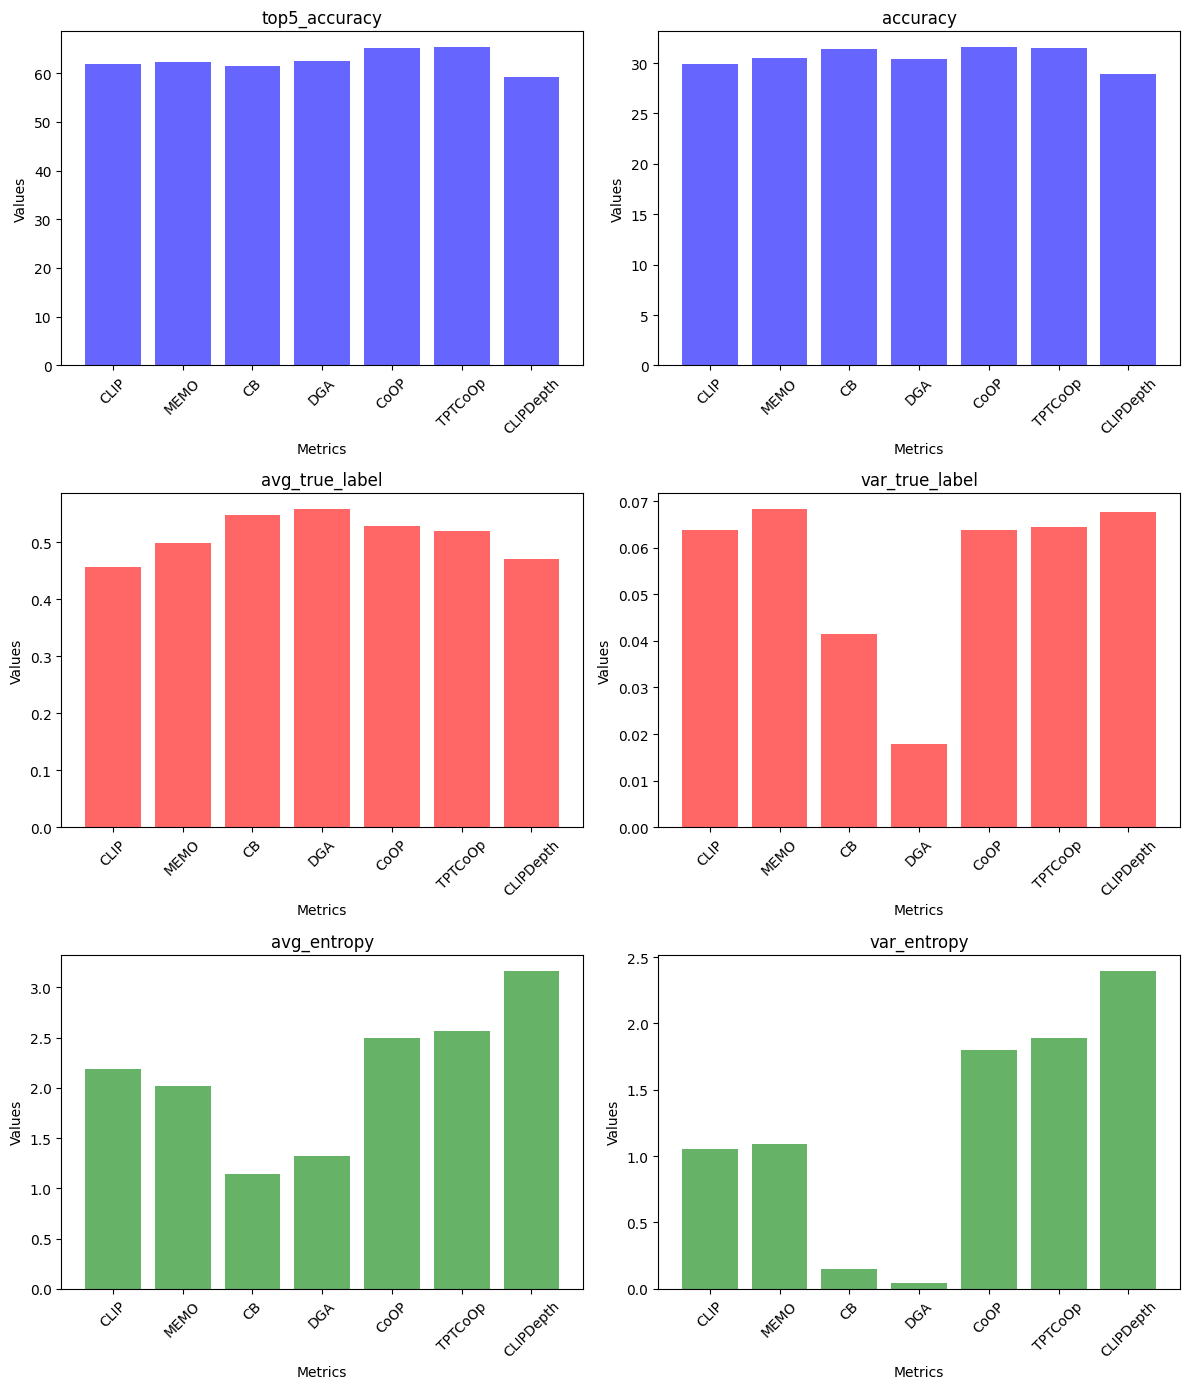

In [6]:
# Loading the .json files
CLIP_stat = get_statistics('CLIP_Base_results.json')
MEMO_stat = get_statistics('MEMO_results.json')
CB_stat = get_statistics('CB_results.json')
DGA_stat = get_statistics('DGA_results.json')
CoOP_stat = get_statistics('CoOp_results.json')
TPTCoOp_stat = get_statistics('TPT_results.json')
CLIPDepth_stat = get_statistics('CLIP+Depth_results.json')

results = pd.DataFrame([CLIP_stat, MEMO_stat, CB_stat, DGA_stat, CoOP_stat, TPTCoOp_stat, CLIPDepth_stat],
                       columns = ['top5_accuracy', 'accuracy', 'avg_true_label', 'var_true_label', 'avg_entropy', 'var_entropy'],
                       index = ['CLIP', 'MEMO', 'CB', 'DGA', 'CoOP', 'TPTCoOp', 'CLIPDepth'])


#Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.flatten()

colors = ['blue', 'blue', 'red', 'red', 'green', 'green']

# Plot histograms for each column
for i in range(len(results.columns)):
    ax = axes[i]
    plot_histogram(results.iloc[:, i].tolist(), ax, title = results.columns[i], color = colors[i])

plt.tight_layout()
plt.show()


## 3.4 Conclusions


*   **Accuracy**

  ```CB```, ```CoOp``` and ```CoOp + TPT``` scored
  the best results with a decent margin over the other competitors. It's quite interesting to note that ```CoOp``` had a slightly better score compared to its implementation combined with the usage of ```TPT```. Having a closer look at the top 5 accuracy, we can see that ```TPT``` is higher than ```CoOp``` and also the average rank of the true label is lower as well. This suggests that ```TPT``` does indeed rise the probability of the true label on average with respect to ```CoOp``` but that has not translated into having them as the top prediction more frequently.
  Although ```CB``` is among the best performing methods for top-1 accuracy, it is also among the worst ones for top-5 accuracy.
  ```DGA``` improves by 0.4 percent the standard ```CLIP``` model, which is not a lot, but considering that it does not rely on anything but some pre-testing additional labels it may be considered as a better starting point with respect to the baseline.
  ```MEMO``` is just 0.1% points better than ```DGA```.

*   **Time Taken**

  It's quite clear that the 2 methods that have to go into a backpropagation step of clip's model, i.e. ```MEMO``` and ```TPT```, have quite a big disadvantage in this term, with ```CoOp + TPT``` taking more than 3 hours and ```MEMO``` taking almost 2 hours to complete the testing phase whereas the rest of them don't surpass 50 minutes.
  ```CLIP``` baseline takes just under 2 minutes and the only algorithm quite close to this result is ```DGA```.  Both ```CB``` and ```CoOp``` implementations take a reasonable but not exhaggerated amount of time, because of augmentations in the first methods, and because of the Propmt Learner in the second.

*   **True label probability**

  ```DGA``` is consistently giving high probability to the true label (highest mean and very low variance). Which is surprising because the accuracy is not greater than the rest of the methods.

*   **Entropy**

  It's results about entropy for ```CB``` and ```DGA``` are misleading, as their probability distribution outputs is just over a few candidates, giving probability 0 to every other class non included. This artificially decreases the entropy by quite a good amount, so we'd better not take them into consideration at all.
  ```MEMO``` method has the lowest entropy out of anyone, and since the backpropagation step is focused exactly on reducing this value, it is not a big surprise. Instead, it is curious to note that both ```CoOp``` and ```CoOp + TPT``` have an higher value compared to the standard ```CLIP``` model.


Overall, ```CoOp``` and ```CB``` seem (further testing on more datasets should be done) the best methods, having some good accuracy without being too computationally expensive. However, whilst ```CoOp``` leverages an external structure, ```CB``` just uses scalar products to select "good" augmentations, making it a simpler tool to work with. Moreover, since our work presents just a first implementation of such a new method, we think that there may be some room to further improve it.
```

# Extra: Depth estimation

### Model explanation

Depth Anything is a robust monocular depth estimation model with an encoder-decoder architecture: DINOv2 encoder for feature extraction and DPT decoder for depth regression. It was trained on labeled data (acquired from sensors, stereo matching, SfM...) and unlabeled data using a Teacher-Student scheme (a pretrained teacher on the labeled data is used to label the unlabeled data, then the student is trained on a combination of both datasets).

Notice that we are using V1 small (24.8M parameters) version of the model, but recently (June 2024) V2 was released with reported higher accuracy.

The following is an image from the original paper:

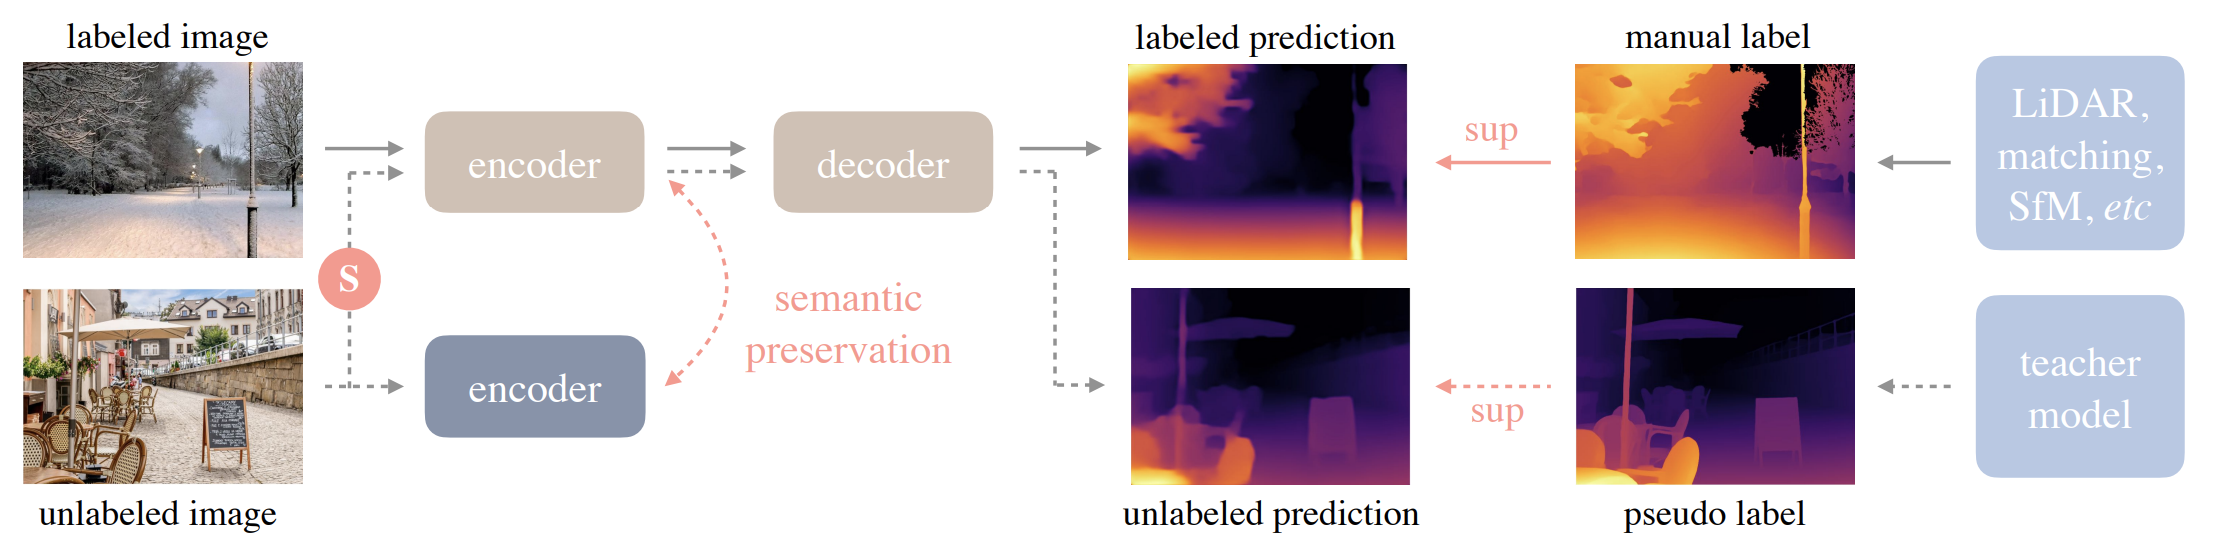
Pipeline. Solid line: flow of labeled images, dotted line: unlabeled images. In light brown the online student model and in blue the frozen encoder to preserve semantic capability. The S denotes some perturbations to address that the teacher and student share the same pre-training and architecture.

Printing the model we can have a close look at its architecture:

1. **Encoder: DinoVisionTransformer**
   - Uses a patch embedding layer with 14x14 patches and 384 output channels
   - Contains 12 NestedTensorBlock layers
   - Each block includes self-attention (MemEffAttention) and MLP layers
   - Final LayerNorm layer with 384 features

2. **Decoder: DPTHead**
   - 4 project layers that convert 384-channel features to varying channel depths (48, 96, 192, 384) implemented as 1x1 convolutions.
   - 4 resize layers for feature map size adjustment
   - A "scratch" module containing:
     - 4 refinement layers (layer1_rn to layer4_rn), each outputting 64 channels
     - 4 FeatureFusionBlocks for progressive feature refinement
     - Output convolutions reducing channel count to 32, then to 1 for the final depth map

3. **Notable Aspects**
   - Utilizes a vision transformer architecture for the encoder
   - Employs a multi-scale feature fusion approach in the decoder
   - Uses residual connections in the FeatureFusionBlocks
   - Final output includes ReLU activations, ensuring non-negative depth values


In [ ]:
print(depth_model)

DepthAnything(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

### Motivation and implementation

The idea behind using a depth estimation model is to separate the pixels (and therefore the objects) in the front, middle or back (for example) into separate images, which might help CLIP to classify them better. It is basically a kind of data augmentation crops based on a depth map. However, this might only help when the images that have such differentiated zones and assuming that the depth estimation model would capture them correctly. In case those zones aren't in a certain image, we might be getting bad augmentations that we will ignore with some criteria.

#### Function definitions

We expect CLIP to place the correct answer among the top ones (for imagenet-A, the correct label was among the top 5 with highest probability a 60% of the times), so what we will do to ensure we are not relying on bad crops, is to assert that the best prediction of a zone is among the top predictions of the original image. This is done with the `filter_disagree_with_original` function.

Description of the pipeline implemented in `predict_with_zones`:

- We use `estimate_depth` to get a depth map of the image.
- Then `filter_img_dist` to set to white the pixels out of a percentile of the distance. We have chosen to set the pixels to white rather than croping the image due to the irregular shapes that might have each of the zones.
    - Since the depth map assigns higher values to the closest pixels, the higher percentiles will be the closest ones to the camera and the lower percentiles will be the furthest ones.
- CLIP will classify the original image and its augmentations.
- At this point we have a probability distribution for each image. We then rule out the augmentations which predict something that is not among the top predictions of the original image (by default, set to top 6). This is implemented by `filter_disagree_with_original`.
- They are averaged using by weights the inverse Shanon entropy (to the power of some exponent that is set as a hyperparameter to make the differences greater).
    - This choice is based on the idea that lower entropy reflects hiegher confidence in the prediction.  
- The final prediction is the class with the highest probability from the average distribution.

__Hyperparameters:__
- `num_zones` (int): How many zones we want to divide the image in. It sets the division of the uniformly distributed percentiles of distances.
- `exp` (int): It is the power to which we elevate the weights when taking the average. Since the image is essentially the original one with ocluded zones, the entropies might not differ by much. Therefore, it is needed to take a higher exponent in order to exploit those small differences.
- `disagree_filter` (bool): Whether we apply `filter_disagree_with_original` or not.
- `acc` (bool): Instead of having different zones like close, mid-distance and far. We could accumulate them by taking close, close with mid-distance and close with mid-distance with far (the last of those is excluded since it is the original image).
    - The intuition behind this last adjustment is that some images with only one object and a background behind it, might have the object sliced between close and mid-distance points. By accumulating them, we get an augmentation of that complete object without the background.

In [ ]:
def estimate_depth(image, depth_model):
    transform = transforms.Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
    ])

    image = np.array(image) / 255.0
    if image.ndim == 2:  # Check if the image is grayscale
        image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB by stacking
    elif image.shape[-1] == 4:  # Check if the image has an alpha channel
        image = image[..., :3]  # Remove the alpha channel
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0)

    # Assuming 'image' is your input tensor and you have already imported torch
    if torch.cuda.is_available():
        image = image.cuda()  # Move the tensor to the default GPU
    else:
        print("CUDA is not available.")
    depth_map = depth_model(image)
    return depth_map


def filter_img_dist(original_img, depth, lower_quantile=0.25, upper_quantile=0.75):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Calculate threshold based on the depth quantiles
    lower_threshold = depth.quantile(lower_quantile)
    upper_threshold = depth.quantile(upper_quantile)

    # Create a mask where depth values are within the specified quartile range
    mask = (depth >= lower_threshold) & (depth <= upper_threshold)

    # Reshape the mask to match the batch dimension (N, H, W)
    mask = mask.squeeze(0).float()  # Remove the batch dimension (e.g., 1, 518, 784)

    # original_img.size gives (width, height), and we need (height, width) for the resize target size
    target_height, target_width = original_img.size[1], original_img.size[0]

    # Resize the mask to match the size of the original image using 'nearest' interpolation
    mask_resized = F.interpolate(mask.unsqueeze(0).unsqueeze(0),
                                 size=(target_height, target_width),
                                 mode='nearest').squeeze(0).squeeze(0)  # Remove extra dimensions


    original_img = np.array(original_img) / 255.0
    if original_img.ndim == 2:  # Check if the image is grayscale
        original_img = np.stack([original_img] * 3, axis=-1)  # Convert grayscale to RGB by stacking
    elif original_img.shape[-1] == 4:  # Check if the image has an alpha channel
        original_img = original_img[..., :3]  # Remove the alpha channel

    # Convert original image to tensor
    original_img_tensor = torch.from_numpy(original_img).float()
    original_img_tensor = original_img_tensor.permute(2, 0, 1).to(device)  # Change from HWC to CHW format for PyTorch

    # Ensure it's in uint8
    if original_img_tensor.max().item() <= 1.0:
        original_img_tensor = (original_img_tensor * 255).byte()  # Scale to 0-255 and convert to uint8

    # Prepare white image tensor, ensuring it matches the device and dtype of original image tensor
    white_img_tensor = torch.ones_like(original_img_tensor, device=device) * 255  # Use 255 to represent white in uint8

    # Ensure mask is expanded to all RGB channels correctly
    mask_rgb = mask_resized.unsqueeze(0).repeat(3, 1, 1).to(device)  # Repeat the mask for 3 channels (3, H, W)

    # Combine original image and white image based on the resized mask
    combined_img_tensor = torch.where(mask_rgb.bool(), original_img_tensor, white_img_tensor)

    # Convert the final tensor to a PIL image
    final_image = to_pil_image(combined_img_tensor)
    return final_image



# (The index 0 correspond to the original image prediction)
def filter_disagree_with_original(probs_list, entropy_list, top=6):
    # Step 1: Get the top indices from the first tensor (reference tensor)
    _, top_indices = torch.topk(probs_list[0], top)
    top_indices_set = set(top_indices.tolist())  # Convert to a set for efficient lookup

    # Step 2: Iterate over the remaining tensors in the list, backwards
    # Start from the end to avoid indexing issues after removal
    for i in range(len(probs_list) - 1, 0, -1):
        top1_index = torch.argmax(probs_list[i]).item()  # Get the index of the highest value
        # Step 3: Check if this index is not in the top indices
        if top1_index not in top_indices_set:
            # Remove from original lists if the condition is not met
            del probs_list[i]
            del entropy_list[i]

    return probs_list, entropy_list


def predict_with_zones(image, depth_model, clip_model, num_zones = 3, exp = 2, disagree_filter = True, acc = False):
    # Estimate the depth map of the image
    depth_map = estimate_depth(image, depth_model)

    # Calculate the percentiles for zoning
    percentiles = np.linspace(0, 1, num_zones + 1)
    probs_list = []
    entropy_list = []

    # Original predict using the entire image
    _, probs, entropy = clip_model(image)
    probs_list.append(probs)
    entropy_list.append(entropy)

    # Iterate through each zone to predict and compute probabilities and entropies
    # Notice we iterate the percentiles from 1 to 0 because the higher the percentile, the closer the points are. We want to accumulate from close to far.
    for i in range(num_zones - 1 if acc else num_zones):
        start_index = -1 if acc else -1-i
        img_filtered = filter_img_dist(image, depth_map, percentiles[-2-i], percentiles[start_index])
        _, probs, entropy = clip_model(img_filtered)
        probs_list.append(probs)
        entropy_list.append(entropy)

    # Filter out the ones that disagree with the top predictions of the original image
    if disagree_filter:
        probs_list, entropy_list = filter_disagree_with_original(probs_list, entropy_list, top=6)

    # Calculate the weighted average of the probabilities according to the inverse entropy
    inverse_entropy = torch.tensor([1.0 / e ** exp if e > 0 else 1e18 for e in entropy_list])
    normalized_weights = inverse_entropy / inverse_entropy.sum()
    weighted_avg_probs = sum(weight * probs for weight, probs in zip(normalized_weights, probs_list))

    # Determine the predicted class by finding the max probability index
    prediction = torch.argmax(weighted_avg_probs).item()

    # Compute the entropy of the weighted probability distribution
    avg_entropy = float(shanon_entropy(weighted_avg_probs))

    return prediction, weighted_avg_probs, avg_entropy


#### Example

Using as an example a photo of a German Sheperd Dog from the Imagenet-A dataset (in specific, the one that performed the worst in this class for CLIP base, it was ranked the 84-th most likely prediction). Before feeding the image through the depth model, we apply some transformations that we have also ploted, as well as the heat map of the depth estimation.

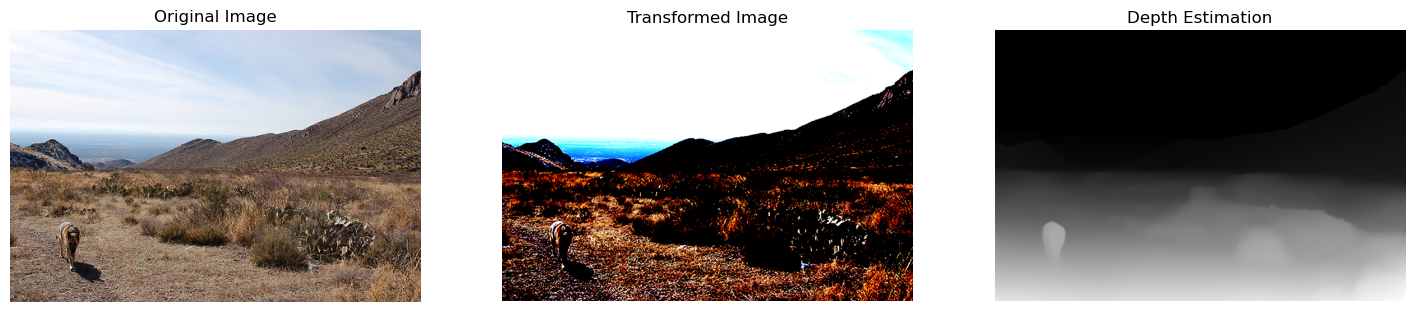

Then, applying the `filter_img_dist` we can extract the pixels between the percentiles 0.7 and 0.9 to get the following image, where we would expect CLIP to classify better the dog.

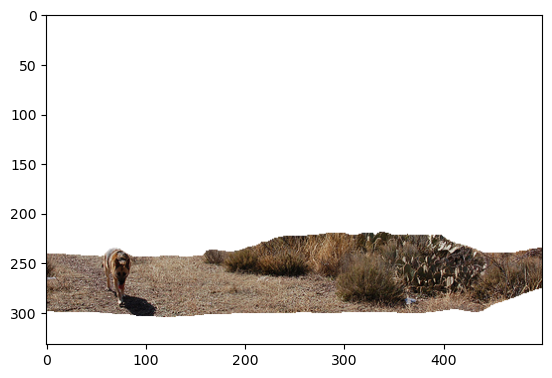

### Testing Depth+CLIP

In [ ]:
testing_depth(imageneta, base_clip, depth_model, batch_size=32, num_zones= 3, exp = 5, disagree_filter = True, acc = False, save_results=True)

100%|██████████| 235/235 [17:44<00:00,  4.53s/it]


Accuracy: 28.89%
Average entropy across all predictions: 3.17
Average confidence across all predictions: 0.47


In [ ]:
# Display global insights
display_global_insights(result_insights)

                      Global Insights                       
------------------------------------------------------------
Global Top-5 Accuracy:                   59.20%
Global Average Correct Entropy:          2.3928
Global Average Incorrect Entropy:        3.4819
Global Average Rank of True Label:       14.65
Global Average Probability of True Label: 0.4711

------------------------------------------------------------


### Conclusions

In the end, this implementation of the depth model did not manage to achieve higher accuracy consistently over the whole dataset but it did over a small subset. We conclude that it seems an interesting approach to get better data augmentations that might be useful together with other methods that benefit from them instead of using random crops. Further exploration of different approaches would be needed and other models with object detection or Region Proposal methods might work better the depth estimation ones.

# References


1. Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021). [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020). *arXiv preprint arXiv:2103.00020*.

2. Wang, H., Ge, S., Xing, E. P., & Lipton, Z. C. (2021). [MEMO: Test Time Robustness via Adaptation and Augmentation](https://arxiv.org/pdf/2110.09506). *arXiv preprint arXiv:2110.09506*.

3. Shu, Y., Wang, W., Bai, S., & Wang, H. (2022). [Test-Time Prompt Tuning for Zero-Shot Generalization in Vision-Language Models](https://arxiv.org/pdf/2209.07511). *arXiv preprint arXiv:2209.07511*.

4. Yang, L., Kang, B., Li, X., Zhao, F., Zhang, J., Xiao, B., & Song, L. (2024). [Depth Anything: Unleashing the Power of Large-Scale Unlabeled Data](https://arxiv.org/abs/2401.10891). *arXiv preprint arXiv:2401.10891*.
   
   [GitHub Repository](https://github.com/LiheYoung/Depth-Anything)

5. Zhou, K., Yang, J., Loy, C. C., & Liu, Z. (2021). [Learning to Prompt for Vision-Language Models](https://arxiv.org/abs/2109.01134). *arXiv preprint arXiv:2109.01134*.